# Overview

This project analyzes the needs of Microsoft Corporation, who is considering adding a movie studio to their business portfolio. Descriptive analysis of movie genres, composers, directors, release year, runtime, production budget and target audience shows recommendations for the previously stated in an attempt to maximize financial gain: (1) Genre: Animation or Adventure; (2) Composer: Ed Côrtes; (3) Director: John Woo or Matt Bettinelli-Olpin; (4) Release Year: partner with existing studio to produce; (5) Runtime: feature film length; (6) Production Budget: lower budget linked to higher profitability; (7) Target Audience: 'PG' rating. Sample data from online movie databases is used to correlate movie characteristics with financial success in order to ultimately perform this analysis. Microsoft Corporation can use this data to plan out relevant details for its first studio production. 

# Business Problem

Similar to other large tech companies, Microsoft has made the decision to create a movie streaming service, complete with their own originally produced content. As this is an entirely new venture for Microsoft, they need guidance in order to make the service successful. Specifically, they need to know what sort of movies to produce. As this is a fairly open-ended objective, it is the responsibility of the data science team to both quantify the term "success" as well as determining drivers that lead to such success.

Since Microsoft is a business whose overall goal is to make money, the data science team chooses to quantify a film's success by its financials. As such, three main and basic financial indicators are used in order to determine whether or not a film is a success. These indicators are gross revenue, net profit, and percent return on investment.
    
Realizing that movie quality (or critical acclaim) could be considered a separate gauge success not necessarily represented in a film's financials, the team adds a fourth metric to its success indicators that weights return on investment by popular quality vote from internet movie databases. This last metric will subsequently be referred to as the success composite and is calculated by multiply ROI by the film's popular quality rating out of ten. Altogether then, the criteria used to define a film's success is as follows:

    1. Gross Revenue
    2. Net Profit (Revenue minus production costs)
    3. Percent Return on Investment (ROI)
    4. Success Composite (Quality-weighted ROI)

With this criteria established, it is the task of the data science team to find what drivers maximize those four metrics. To do so, the team runs an analysis on historical movie data from IMDB to identify specific movie traits that lead to success. In particular, the following seven characteristics are examined:

    1. Genre
    2. Runtime (Length)
    3. Production Budget
    4. Target Audience
    5. Director
    6. Composer
    7. Release Year

Overall, then, it is the goal of the data science team to answer the questions, "To what degree does each one of these traits influence a film's success? And what exactly is the nature of that influence?" Armed with this knowledge, Microsoft will have an idea of the approximate profiles of films they should make for their streaming service.

# Data Understanding

Mentioned in the Business Problem, the team is using historical film data in order to run analyses and find trends. This data comes from the following online movie databases:

    - Box Office Mojo
    - IMDB
    - Rotten Tomatoes
    - The MovieDB.org
    
From these data bases, four particular files are mainly used (imdb.title.basics.csv.gz, tn.movie_budgets.csv.gz, imdb.title.akas.csv.gz, imdb.title.ratings.csv.gz). These files specifically contain all financial data necessary for calculating the four success indicators (production budgets, worldwide gross revenues, popularity rating), as well as all seven film characteristics to be examined. This info is then merged in order to link together each of these bits of info together, at which point film characteristics can be correlated to success metrics to determine their impact.

Movie sample sizes between the different files range from thousands of entries to hundreds of thousands. To maintain integrity and completeness of the data, movies with missing information for any of the success criteria or examined characteristics are omitted. Additionally, movies with less than 100 viewer ratings on IMDB are intentionally omitted as well to ensure the legitimacy of the film. It will be discussed later in the analysis, but web calls and scrubbing of IMDB is also used in order to supplement gaps in supplied data for MPAA ratings.

# Data Preparation

Data is first imported from the project GitHub repository into the notebook.

In [1]:
import os
import pandas as pd 

In [2]:
data_path = os.path.join('data','zippedData')
data_files = os.listdir(data_path)
data_files.pop(data_files.index('Untitled.ipynb'))
data_files = [os.path.join(data_path,file) for file in data_files]
data_files

['data/zippedData/imdb.title.crew.csv.gz',
 'data/zippedData/tmdb.movies.csv.gz',
 'data/zippedData/imdb.title.akas.csv.gz',
 'data/zippedData/imdb.title.ratings.csv.gz',
 'data/zippedData/imdb.name.basics.csv.gz',
 'data/zippedData/rt.reviews.tsv.gz',
 'data/zippedData/imdb.title.basics.csv.gz',
 'data/zippedData/rt.movie_info.tsv.gz',
 'data/zippedData/tn.movie_budgets.csv.gz',
 'data/zippedData/bom.movie_gross.csv.gz',
 'data/zippedData/imdb.title.principals.csv.gz']

All imported data is then consolidated into a single data object (called "data") that is referenced throughout the rest of data manipulation.

In [3]:
data = {}
name_dict={'imdb.title.crew.csv.gz':"crew",
           'tmdb.movies.csv.gz':"movies",
           'imdb.title.akas.csv.gz':"akas",
           'imdb.title.ratings.csv.gz':"ratings",
           'imdb.name.basics.csv.gz':"name_basics",
           'rt.reviews.tsv.gz':"reviews",
           'imdb.title.basics.csv.gz':"title_basics",
           'rt.movie_info.tsv.gz':"movie_info",
           'tn.movie_budgets.csv.gz':"movie_budgets",
           'bom.movie_gross.csv.gz':"movie_gross",
           'imdb.title.principals.csv.gz':"principals"
          }
for file in data_files:
    try:
        df = pd.read_csv(file)
    except:
        print(file)
        continue
    file_name = file.split('/')[-1]
    data[name_dict[file_name]] = df
    
data["movie_info"]=pd.read_csv('data/zippedData/rt.movie_info.tsv.gz', sep="\t")
data["reviews"]=pd.read_csv('data/zippedData/rt.reviews.tsv.gz', sep="\t", encoding="latin1")

data/zippedData/rt.reviews.tsv.gz
data/zippedData/rt.movie_info.tsv.gz


# Cleaning, Merging, and Feature Engineering

In overall data object, columns are first renamed to be a little more wieldy during data manipulation.

In [4]:
#Renaming columns to be able to merge on 'title' and 'tconst' columns

data['title_basics'].rename(columns={'primary_title':'title'}, inplace = True)
data['movie_budgets'].rename(columns={'movie':'title'}, inplace = True)
data['akas'].rename(columns={'title_id': 'tconst'}, inplace = True)

All monetary data is converted into integers to make mathematical operation possible.

In [5]:
#Getting rid of commas and dollar signs to make dataframe values easier to work with 

data['movie_budgets']['worldwide_gross'] = data['movie_budgets']['worldwide_gross'].str.replace(',', '')
data['movie_budgets']['worldwide_gross'] = data['movie_budgets']['worldwide_gross'].str.replace('$', '')
data['movie_budgets']['worldwide_gross'] = data['movie_budgets']['worldwide_gross'].astype(int)

data['movie_budgets']['production_budget'] = data['movie_budgets']['production_budget'].str.replace(',', '')
data['movie_budgets']['production_budget'] = data['movie_budgets']['production_budget'].str.replace('$', '')
data['movie_budgets']['production_budget'] = data['movie_budgets']['production_budget'].astype(int)

Movies with less than 100 review votes from IMDB are filtered out to ensure that all movies within the master data sample are legitimate. 

In [6]:
#Filter ratings dataframe to a minimum of 100 votes

data['ratings'] = data['ratings'][data['ratings'].numvotes >= 100]

All data from different tables is merged into one singular table for ease of manipulation. Rows with null values in relevant categories (any related to success criteria or examined traits) are filtered out.

In [7]:
#Merging data on tconst

tconst_to_title = pd.merge(data['akas'],data['ratings'],on='tconst')

In [8]:
tconst_to_title.head(1)

,tconst,ordering,title,region,language,types,attributes,is_original_title,averagerating,numvotes
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0,7.0,539338


In [9]:
#Dropping uncessary columns from tconst_to_title dataframe

tconst_to_title = tconst_to_title.drop(columns=['ordering','region','language','types','attributes','is_original_title'])
data['movie_budgets'] = data['movie_budgets'].drop(columns=['release_date','domestic_gross'])

In [10]:
tconst_to_title.head(1)

,tconst,title,averagerating,numvotes
0,tt0369610,Джурасик свят,7.0,539338


In [11]:
#Merging tconst_to_title dataframe with movie_budgets dataframe on 'title' column

master_table = pd.merge(tconst_to_title,data['movie_budgets'],on='title')

In [12]:
master_table.head(1)

,tconst,title,averagerating,numvotes,id,production_budget,worldwide_gross
0,tt0369610,Jurassic World,7.0,539338,34,215000000,1648854864


Three of the four success indicators are engineered and added to the master data table. These are the success composite, ROI, and net profit.

In [13]:
#Defining 'Composite Quality Score', Net Profit and ROI to help define successful movies

master_table['success_score'] = master_table.averagerating * (master_table.worldwide_gross / master_table.production_budget)
master_table["roi"]=master_table.worldwide_gross/master_table.production_budget
master_table["net_profit"]=master_table.worldwide_gross-master_table.production_budget

In [14]:
#Dropping duplicates from 'tconst' column in master_table dataframe

master_table.drop_duplicates(subset = ['tconst'],inplace=True)

In [15]:
#Merging title_basics dataframe to master_table dataframe on tconst

master_table = pd.merge(data['title_basics'],master_table,on='tconst')

In [16]:
#Merging movie_info dataframe to master_table dataframe

master_table = pd.merge(master_table, data['movie_info'],on='id')

In [17]:
master_table.head(1)

,tconst,title_x,original_title,start_year,runtime_minutes,genres,title_y,averagerating,numvotes,id,...,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",Saving Grace,8.1,263,95,...,R,Drama|Sports and Fitness,Ben Younger,Ben Younger,"Nov 18, 2016","Feb 14, 2017",$,"5,051,927",116 minutes,Open Road Films


In [18]:
#Drop remaining unnecessary columns

master_table.drop(columns=['original_title','title_y','theater_date','dvd_date','currency','box_office','studio','synopsis','runtime','writer'], inplace=True)

In [19]:
master_table.head(1)

,tconst,title_x,start_year,runtime_minutes,genres,averagerating,numvotes,id,production_budget,worldwide_gross,success_score,roi,net_profit,rating,genre,director
0,tt0137204,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",8.1,263,95,4000000,27786849,56.268369,6.946712,23786849,R,Drama|Sports and Fitness,Ben Younger


In [20]:
master_table.sort_values(by='worldwide_gross', ascending = False, inplace=True)

In [21]:
master_table = master_table.dropna(subset = ['director'])

In [22]:
#Creating df_composer dataframe for analyzing composer against success indicators

df_composer = data['name_basics'].dropna(subset=['primary_profession','known_for_titles'])
df_composer["title_length"]=df_composer["known_for_titles"].map(lambda x: x.count(',') + 1)
df_composer = df_composer[df_composer.primary_profession.str.contains('composer')]

/Users/benspilsbury/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [23]:
#sorting for most popular composers

df_composer.sort_values(by='title_length',ascending=False, inplace=True)

In [24]:
#Making composer dataframe by making tconst individualized

tconsts=list(df_composer["known_for_titles"][:32])
tconst_list=[]
for tconst in tconsts:
    tconst_list.append(list(tconst.split(",")))
tconst_list
tconst_master=[]
for tconst in tconst_list:
    for subtconst in tconst:
        tconst_master.append(subtconst)
        
unique_tconst_master=set(tconst_master)
vector=list(range(0,46984))
df_tconst=[]
df_consts=[]

for tconst in unique_tconst_master:
    for number in vector:
        if tconst in df_composer.iloc[number, 5]:
            df_tconst.append(tconst)
            df_consts.append(df_composer.iloc[number, 1])
            
tconst_table=pd.DataFrame({'composer':df_consts, 'tconst':df_tconst})

tconst_table

,composer,tconst
0,Mark Morton,tt2571782
1,Sebastien Pan,tt4851640
2,Scott Karahadian,tt1756424
3,Lisa Holmqvist,tt3749338
4,Amie Doherty,tt2802850
...,...,...
199,Ilima Considine,tt0489013
200,Greg Ives,tt0489013
201,Mark Morton,tt0478209
202,Sebastian Laskowski,tt5662632


In [25]:
#Merging master with composer table

master_composer = pd.merge(master_table,tconst_table, on='tconst')

In [26]:
#Removing deceased composers and problem data

master_composer = master_composer[master_composer.composer != 'Matthew Emerson Brown']
master_composer = master_composer[master_composer.composer != 'Joshua Morrison']
master_composer = master_composer[master_composer.composer != 'Jeramy Koepping']
master_composer = master_composer[master_composer.composer != 'Ed Cortes']
master_table = master_table[master_table.director != 'Rodney Bennett']
master_table = master_table[master_table.director != 'Rick Rosenthal']

In [27]:
master_composer.sort_values(by='success_score', ascending = False, inplace = True)

# Analysis

In [28]:
#Importing relevant libraries

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

## What Effect Does Director Have on a Movie's Success?

All movies from the data set were decomposed into their corresponding directors. Each like director was then grouped across all movies in the data set and measured against the four established success indicators (shown in graphs below).

For the revenue and net profit indicators, director John Woo is the leader followed closely by director Matt Bettinelli-Olpin. For the ROI and success score indicators, Jim Jarmusch is the overwhelming leading scorer with a median ROI of almost 12 and a success score of over 75. 

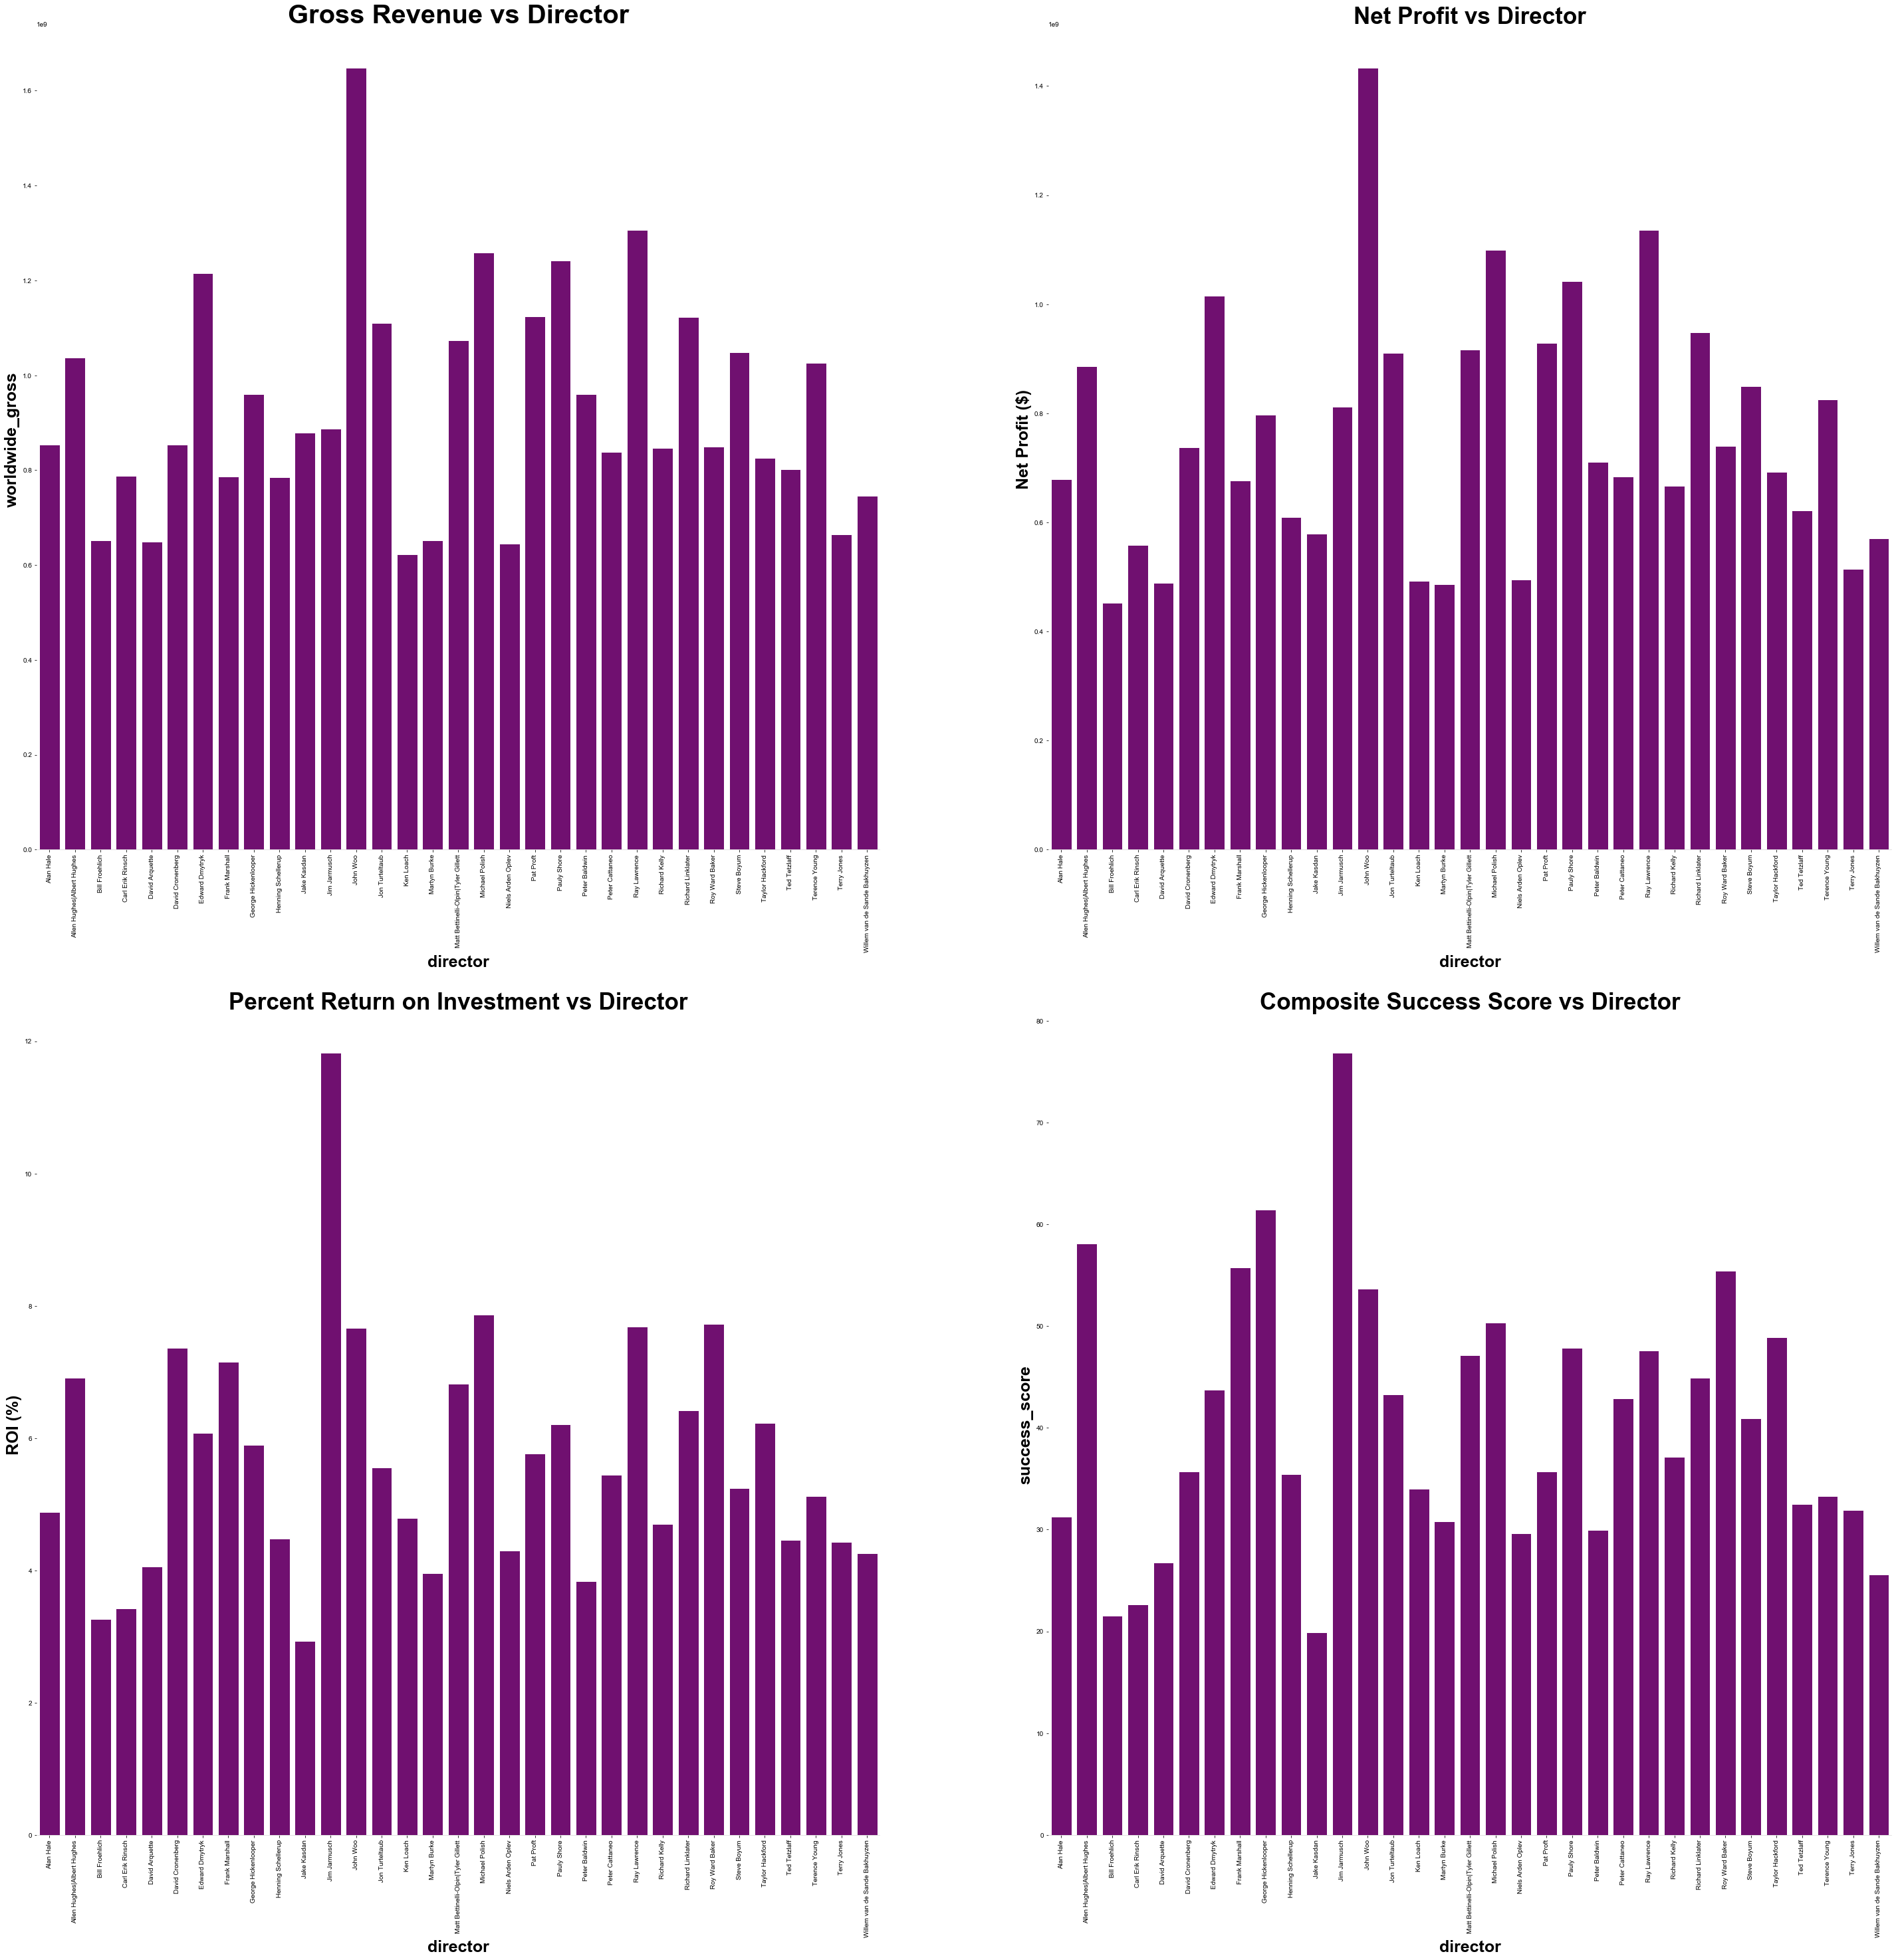

In [30]:
#Graphing Director vs Gross Revenue, Net Profit, ROI, and Success Score

figure, ax = plt.subplots(2, 2, figsize=(50, 50))
x=master_table[:50].groupby("director").median().index

y0_gross_rev= master_table[:50].groupby("director").median().worldwide_gross
y1_net_prof= master_table[:50].groupby("director").median().worldwide_gross-master_table[:50].groupby("director").median().production_budget
y2_roi_percent= master_table[:50].groupby("director").median().worldwide_gross/master_table[:50].groupby("director").median().production_budget
y3_comp= master_table[:50].groupby("director").median().success_score 

ax[0][0].set_title('Gross Revenue vs Director', fontsize = 40, fontweight="bold")
ax[0][0].set_xlabel('Director', fontsize = 25, fontweight="bold")
ax[0][0].set_ylabel('Gross Revenue ($)', fontsize = 25, fontweight="bold")
ax[0][1].set_title('Net Profit vs Director', fontsize = 35, fontweight="bold")
ax[0][1].set_xlabel('Director', fontsize = 25, fontweight="bold")
ax[0][1].set_ylabel('Net Profit ($)', fontsize = 25, fontweight="bold")
ax[1][0].set_title('Percent Return on Investment vs Director', fontsize = 35, fontweight="bold")
ax[1][0].set_xlabel('Director', fontsize = 25, fontweight="bold")
ax[1][0].set_ylabel('ROI (%)', fontsize = 25, fontweight="bold")
ax[1][1].set_title('Composite Success Score vs Director', fontsize = 35, fontweight="bold")
ax[1][1].set_xlabel('Director', fontsize = 25, fontweight="bold")
ax[1][1].set_ylabel('Success Score', fontsize = 25, fontweight="bold")

ax[0][0].set_xticklabels(x,rotation=90)
ax[0][1].set_xticklabels(x,rotation=90)
ax[1][0].set_xticklabels(x,rotation=90)
ax[1][1].set_xticklabels(x,rotation=90)

ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['left'].set_visible(False)
ax[0][0].spines['bottom'].set_color('#DDDDDD')

ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['left'].set_visible(False)
ax[0][1].spines['bottom'].set_color('#DDDDDD')

ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['left'].set_visible(False)
ax[1][0].spines['bottom'].set_color('#DDDDDD')

ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['left'].set_visible(False)
ax[1][1].spines['bottom'].set_color('#DDDDDD')

sns.set_style("whitegrid")
sns.barplot(x, y0_gross_rev, ax=ax[0][0], color='purple')
sns.barplot(x, y1_net_prof, ax=ax[0][1], color='purple')
sns.barplot(x, y2_roi_percent, ax=ax[1][0], color='purple')
sns.barplot(x, y3_comp, ax=ax[1][1], color='purple')

## What Effect Does the Composer Have on a Movie's Success?

All movies from the data set were decomposed into their corresponding composers. Each like composer was then grouped across all movies in the data set and measured against the four established success indicators (shown in graphs below).

The 7 composers featured are those 7 linked to the highest grossing movies of the whole composer dataframe. While there is much variation amongst the four indicator graphs, Ed Côrtes stands out among the 7 composers as the most cross-categorically linked to successful movies as defined by the four indicators. 

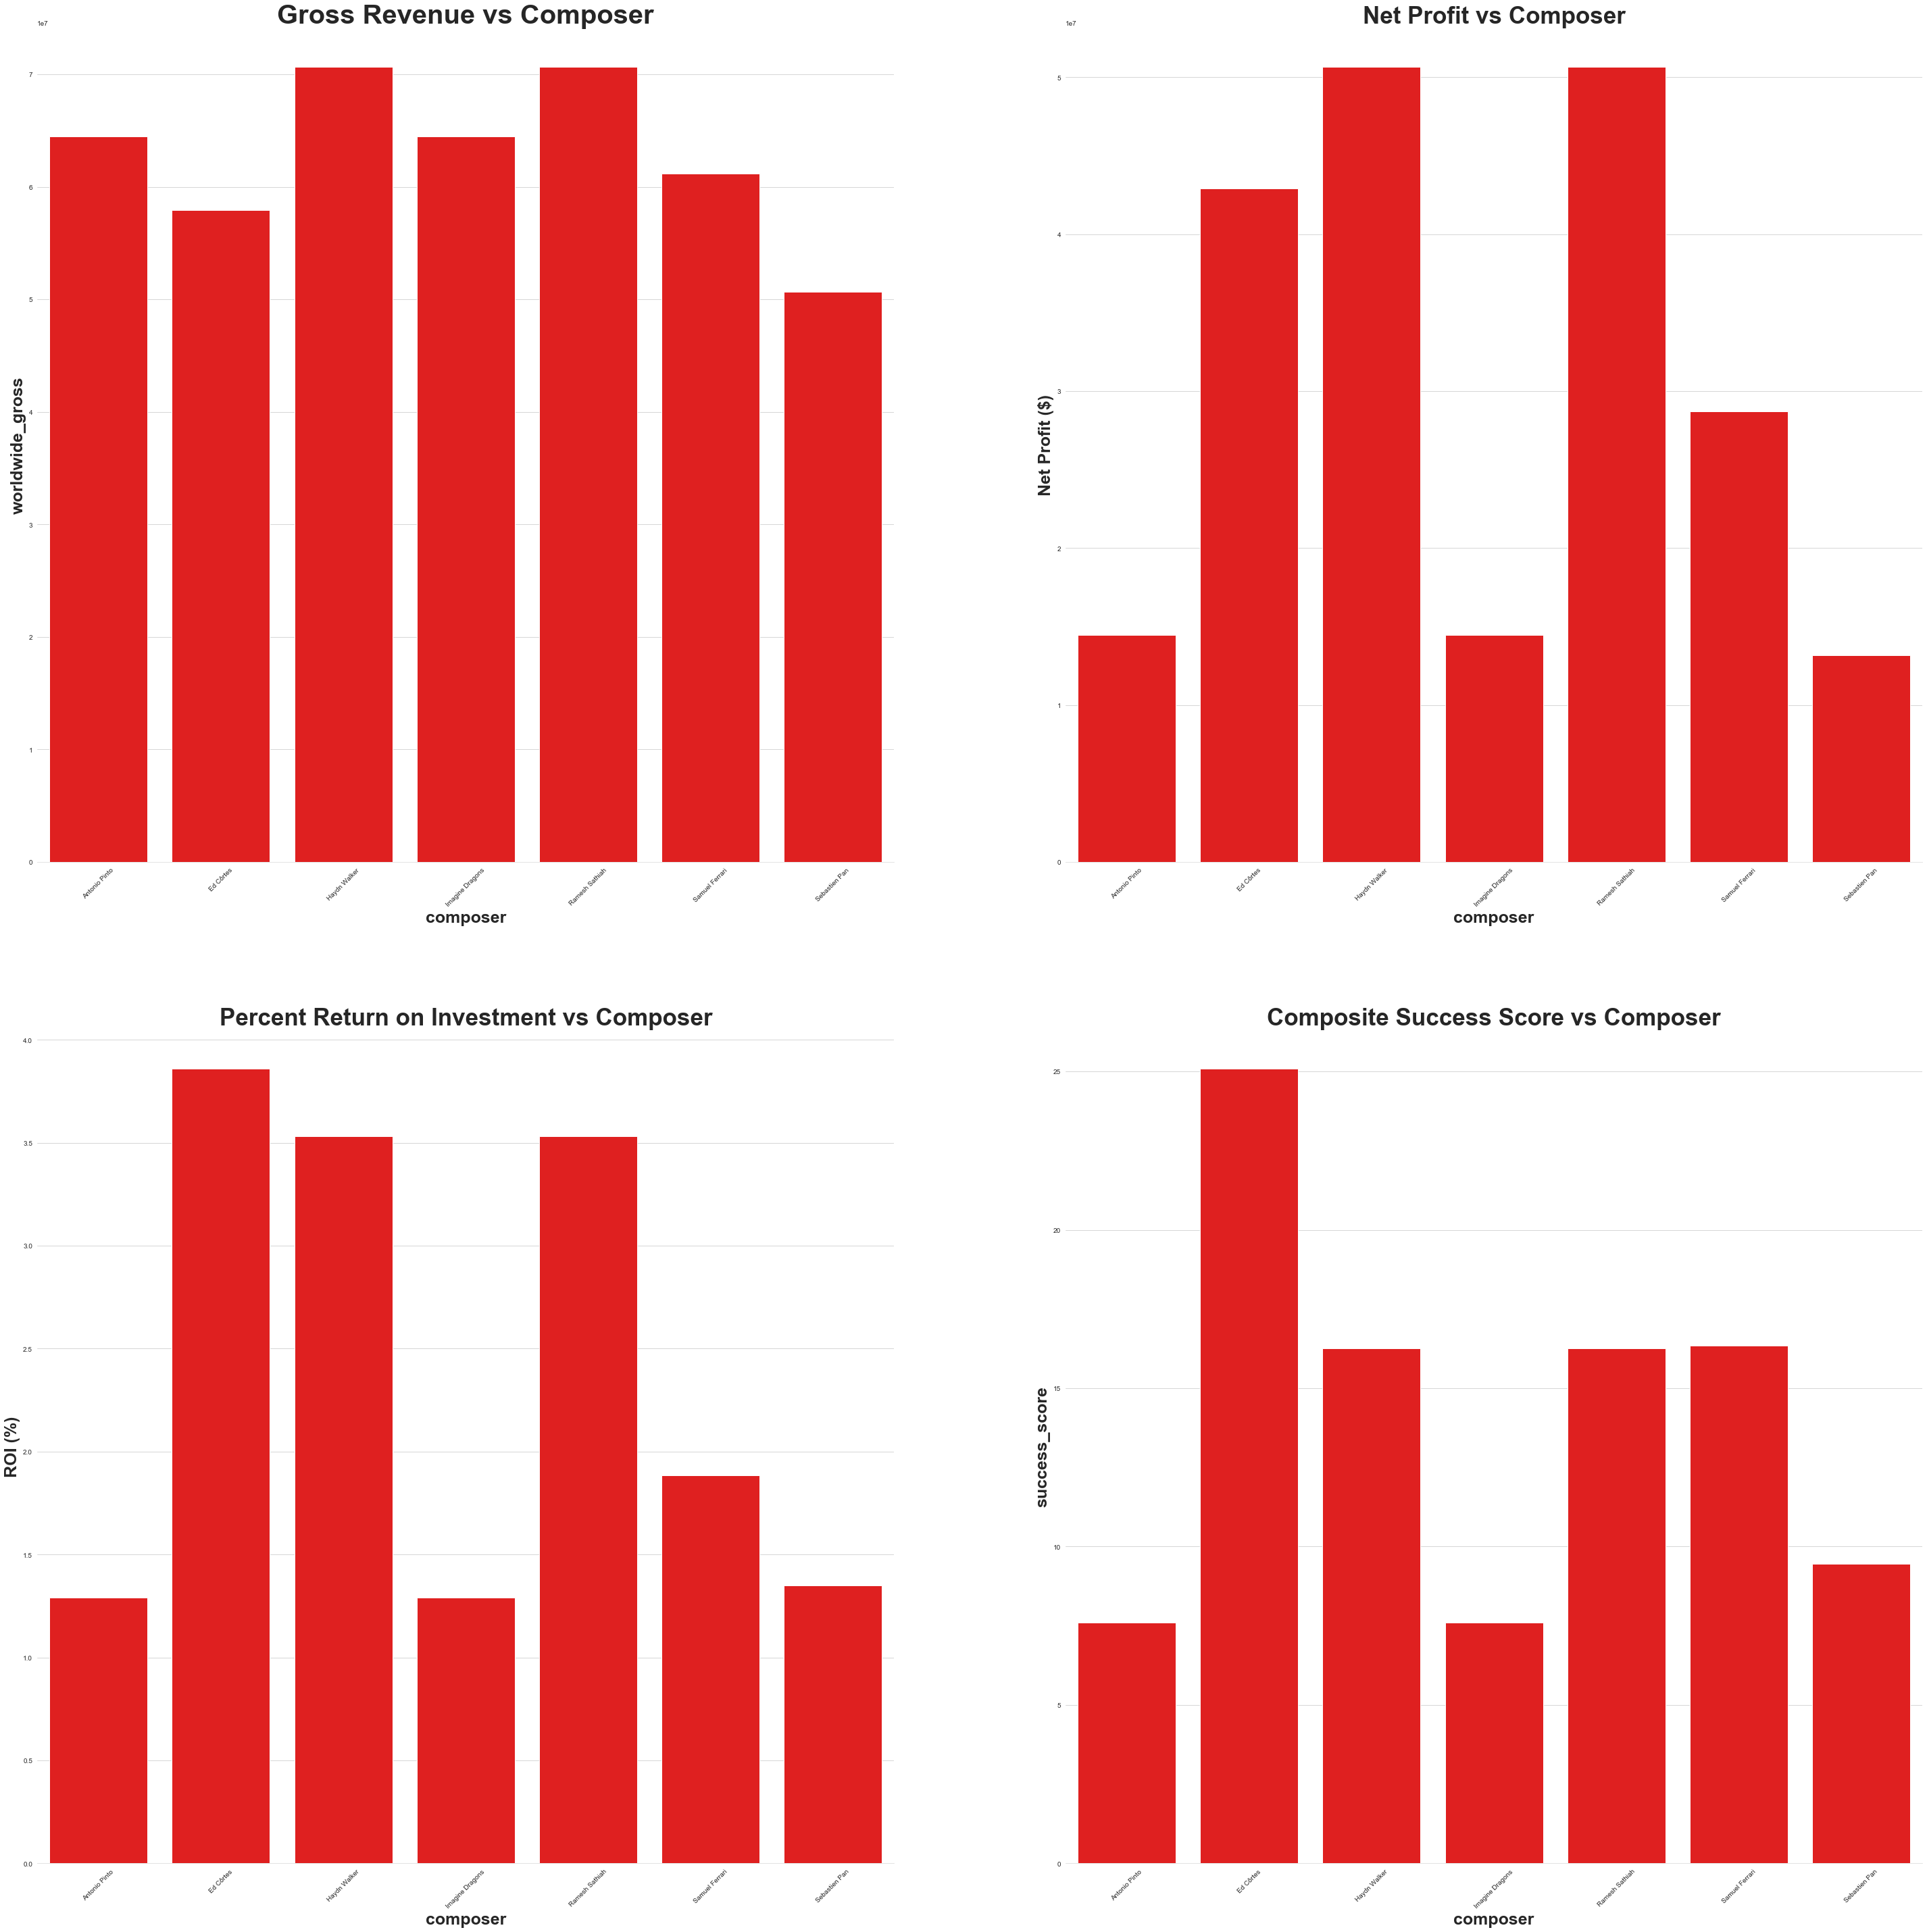

In [31]:
#Graphing Composer vs Gross Revenue, Net Profit, ROI, and Success Score

figure, ax = plt.subplots(2, 2, figsize=(50, 50))
x=master_composer.groupby("composer").median().index
y0_gross_rev= master_composer.groupby("composer").median().worldwide_gross
y1_net_prof= master_composer.groupby("composer").median().worldwide_gross-master_composer.groupby("composer").median().production_budget
y2_roi_percent= master_composer.groupby("composer").median().worldwide_gross/master_composer.groupby("composer").median().production_budget
y3_comp= master_composer.groupby("composer").median().success_score 

ax[0][0].set_title('Gross Revenue vs Composer', fontsize = 40, fontweight="bold")
ax[0][0].set_xlabel('Composer', fontsize = 25, fontweight="bold")
ax[0][0].set_ylabel('Gross Revenue ($)', fontsize = 25, fontweight="bold")
ax[0][1].set_title('Net Profit vs Composer', fontsize = 35, fontweight="bold")
ax[0][1].set_xlabel('Composer', fontsize = 25, fontweight="bold")
ax[0][1].set_ylabel('Net Profit ($)', fontsize = 25, fontweight="bold")
ax[1][0].set_title('Percent Return on Investment vs Composer', fontsize = 35, fontweight="bold")
ax[1][0].set_xlabel('Composer', fontsize = 25, fontweight="bold")
ax[1][0].set_ylabel('ROI (%)', fontsize = 25, fontweight="bold")
ax[1][1].set_title('Composite Success Score vs Composer', fontsize = 35, fontweight="bold")
ax[1][1].set_xlabel('Year', fontsize = 25, fontweight="bold")
ax[1][1].set_ylabel('Success Score', fontsize = 25, fontweight="bold")

ax[0][0].set_xticklabels(x,rotation=45)
ax[0][1].set_xticklabels(x,rotation=45)
ax[1][0].set_xticklabels(x,rotation=45)
ax[1][1].set_xticklabels(x,rotation=45)

ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['left'].set_visible(False)
ax[0][0].spines['bottom'].set_color('#DDDDDD')

ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['left'].set_visible(False)
ax[0][1].spines['bottom'].set_color('#DDDDDD')

ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['left'].set_visible(False)
ax[1][0].spines['bottom'].set_color('#DDDDDD')

ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['left'].set_visible(False)
ax[1][1].spines['bottom'].set_color('#DDDDDD')

sns.set_style("whitegrid")
sns.barplot(x, y0_gross_rev, ax=ax[0][0], color='red')
sns.barplot(x, y1_net_prof, ax=ax[0][1], color='red')
sns.barplot(x, y2_roi_percent, ax=ax[1][0], color='red')
sns.barplot(x, y3_comp, ax=ax[1][1], color='red')

## What Effect Does the Year Have on a Movie's Success? 

All movies from the data set were decomposed into their corresponding release years. Each like year was then grouped across all movies in the data set and measured against the four established success indicators (shown in graphs below). 

For all four indicators, you can see that there is a steep decline in scores across the board for the year 2019 after a general upward trend. Since movie indicator scores over the last 9 years have been quite volatile, there may be nothing to worry about regarding the downward turn. It may also be a good time to get into the business at a discount or partner with a small struggling studio. A possible concern is the sudden drop in ROI after years of maintaining steady percentages. 

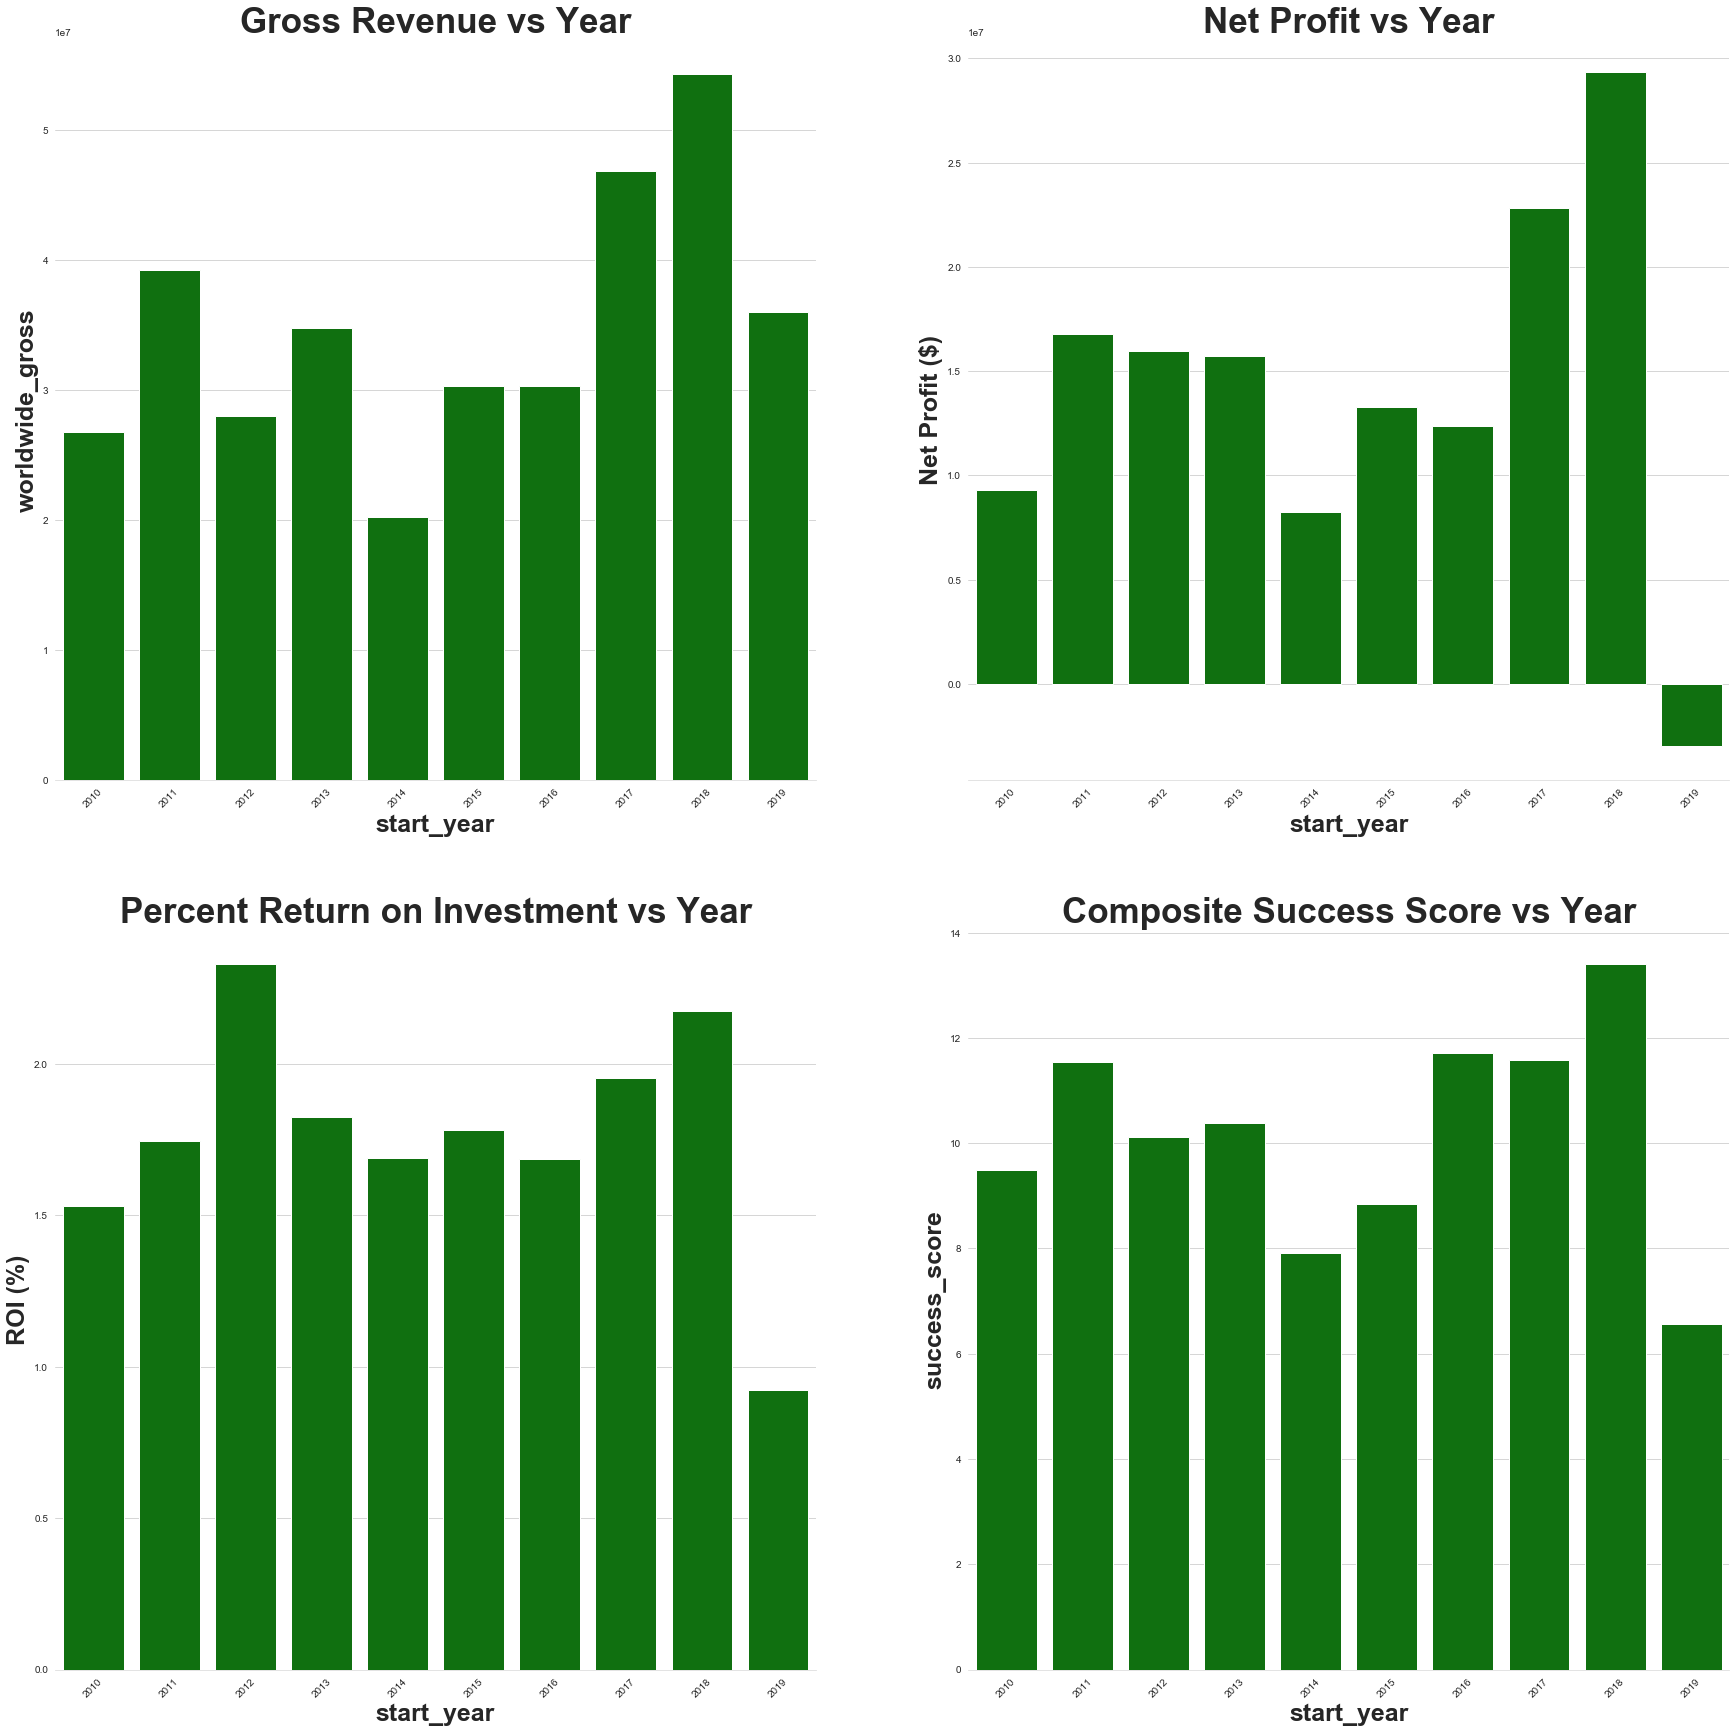

In [32]:
#Graphing Start Year vs Gross Revenue, Net Profit, ROI, and Success Score

figure, ax = plt.subplots(2, 2, figsize=(30, 30))
x=master_table.groupby("start_year").median().index
y0_gross_rev= master_table.groupby("start_year").median().worldwide_gross
y1_net_prof= master_table.groupby("start_year").median().worldwide_gross-master_table.groupby("start_year").median().production_budget
y2_roi_percent= master_table.groupby("start_year").median().worldwide_gross/master_table.groupby("start_year").median().production_budget
y3_comp= master_table.groupby("start_year").median().success_score 

ax[0][0].set_title('Gross Revenue vs Year', fontsize = 35, fontweight="bold")
ax[0][0].set_xlabel('Year', fontsize = 25, fontweight="bold")
ax[0][0].set_ylabel('Gross Revenue ($)', fontsize = 25, fontweight="bold")
ax[0][1].set_title('Net Profit vs Year', fontsize = 35, fontweight="bold")
ax[0][1].set_xlabel('Year', fontsize = 25, fontweight="bold")
ax[0][1].set_ylabel('Net Profit ($)', fontsize = 25, fontweight="bold")
ax[1][0].set_title('Percent Return on Investment vs Year', fontsize = 35, fontweight="bold")
ax[1][0].set_xlabel('Year', fontsize = 25, fontweight="bold")
ax[1][0].set_ylabel('ROI (%)', fontsize = 25, fontweight="bold")
ax[1][1].set_title('Composite Success Score vs Year', fontsize = 35, fontweight="bold")
ax[1][1].set_xlabel('Year', fontsize = 25, fontweight="bold")
ax[1][1].set_ylabel('Success Score', fontsize = 25, fontweight="bold")

ax[0][0].set_xticklabels(x,rotation=45)
ax[0][1].set_xticklabels(x,rotation=45)
ax[1][0].set_xticklabels(x,rotation=45)
ax[1][1].set_xticklabels(x,rotation=45)

ax[0][0].spines['top'].set_visible(False)
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['left'].set_visible(False)
ax[0][0].spines['bottom'].set_color('#DDDDDD')

ax[0][1].spines['top'].set_visible(False)
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['left'].set_visible(False)
ax[0][1].spines['bottom'].set_color('#DDDDDD')

ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['left'].set_visible(False)
ax[1][0].spines['bottom'].set_color('#DDDDDD')

ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['left'].set_visible(False)
ax[1][1].spines['bottom'].set_color('#DDDDDD')

sns.set_style("whitegrid")
sns.barplot(x, y0_gross_rev, ax=ax[0][0], color='green')
sns.barplot(x, y1_net_prof, ax=ax[0][1], color='green')
sns.barplot(x, y2_roi_percent, ax=ax[1][0], color='green')
sns.barplot(x, y3_comp, ax=ax[1][1], color='green')

## What Effect Does Genre Have on a Movie's Success?

All movies from the data set were decomposed into their corresponding genres. Each like genre was then grouped across all movies in the data set and measured against the four established success indicators (shown in graphs below).

Across all four success indicators, Animation and Adventure score overwhelmingly higher than other genres (for instance, Animation's median net profit is over twice that of Action, the third-hightest profiting genre).

<BarContainer object of 22 artists>

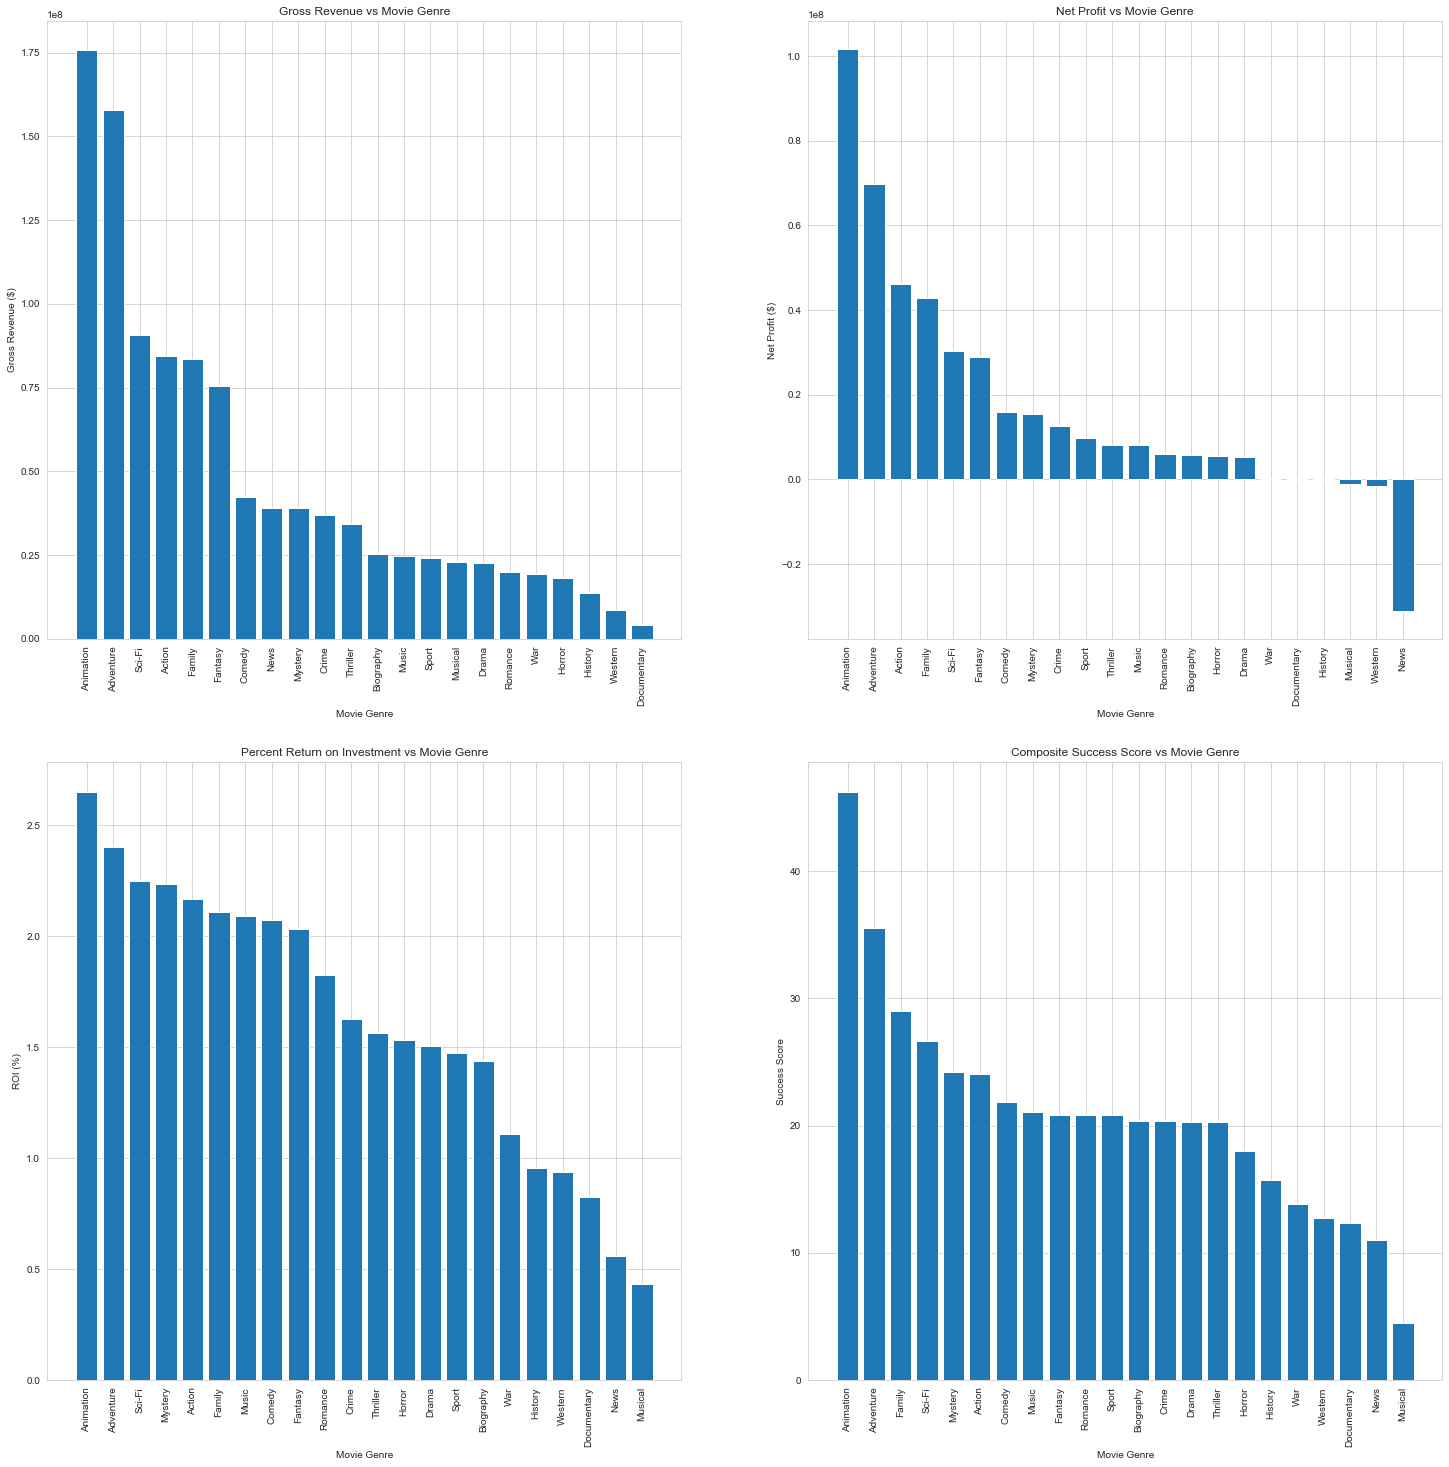

In [33]:
# Extract all values for genre from data set

unique_genre_combos=list(master_table["genres"].unique())

# Values are listed as combinations delimited by commas.
# Separate these combinations into a list of unique genres so that each 
# can be analyzed individually.

genre_list=[]
for genres in unique_genre_combos:
    genre_list.append(genres.split(","))

genre_master=[]
for genre in genre_list:
    for subgenre in genre:
        genre_master.append(subgenre)

unique_genre_master=set(genre_master)

# Using the list of unique genres, loop through the data set to find each movie that is
# aligned to each genre. Create a dataframe documenting these relationships.

vector=list(range(0,len(master_table.tconst)))
df_genres=[]
df_consts=[]

for genre in unique_genre_master:
    for number in vector:
        if genre in master_table.iloc[number, 4]:
            df_genres.append(genre)
            df_consts.append(master_table.iloc[number, 0])

genre_table=pd.DataFrame({'tconst':df_consts, 'ugenre':df_genres})

# Merge the new genre/movie data frame to the master data table in order to link budget data
# back to genre.

complete_genre_table=pd.merge(genre_table, master_table, how="left", on="tconst")

# Graph genre values against each of the four established measures of success

figure, ax = plt.subplots(2, 2, figsize=(25, 25))

# Establish x and y values for plots

x0_gross_rev=complete_genre_table.groupby("ugenre").median().sort_values(by='worldwide_gross', ascending=False).index
x1_net_prof=complete_genre_table.groupby("ugenre").median().sort_values(by='net_profit', ascending=False).index
x2_roi_percent=complete_genre_table.groupby("ugenre").median().sort_values(by='roi', ascending=False).index
x3_comp=complete_genre_table.groupby("ugenre").median().sort_values(by='success_score', ascending=False).index
y0_gross_rev= complete_genre_table.groupby("ugenre").median().sort_values(by='worldwide_gross', ascending=False).worldwide_gross
y1_net_prof= complete_genre_table.groupby("ugenre").median().sort_values(by='net_profit', ascending=False).net_profit
y2_roi_percent= complete_genre_table.groupby("ugenre").median().sort_values(by='roi', ascending=False).roi
y3_comp= complete_genre_table.groupby("ugenre").mean().sort_values(by='success_score', ascending=False).success_score 

# Set axes for all four graphs

ax[0][0].set_title('Gross Revenue vs Movie Genre')
ax[0][0].set_xlabel('Movie Genre')
ax[0][0].set_ylabel('Gross Revenue ($)')

ax[0][1].set_title('Net Profit vs Movie Genre')
ax[0][1].set_xlabel('Movie Genre')
ax[0][1].set_ylabel('Net Profit ($)')

ax[1][0].set_title('Percent Return on Investment vs Movie Genre')
ax[1][0].set_xlabel('Movie Genre')
ax[1][0].set_ylabel('ROI (%)')

ax[1][1].set_title('Composite Success Score vs Movie Genre')
ax[1][1].set_xlabel('Movie Genre')
ax[1][1].set_ylabel('Success Score')

ax[0][0].set_xticklabels(x0_gross_rev,rotation=90)
ax[0][1].set_xticklabels(x1_net_prof,rotation=90)
ax[1][0].set_xticklabels(x2_roi_percent,rotation=90)
ax[1][1].set_xticklabels(x3_comp,rotation=90)

# Graph the four plots

ax[0][0].bar(x0_gross_rev, y0_gross_rev)
ax[0][1].bar(x1_net_prof, y1_net_prof)
ax[1][0].bar(x2_roi_percent, y2_roi_percent)
ax[1][1].bar(x3_comp, y3_comp)

## What Effect Does Runtime Have on a Movie's Success?

All movies in the dataset were sequenced based on their length in minutes. Each movie's corresponding revenue, profit, ROI, and success composite score were then individually plotted against length as single data points. In tandem the correlations between runtime and these four success indicators were calculated in order to determine whether or not runtime is meaningfully related to a movie's success.

In general, there did not appear to be a strong linkage between a movie's runtime and its success. The strongest correlations, which were for gross revenue and net profit, were only weakly positive. No substantive linkage was observed for ROI or success composite score. Overall, then, perhaps the main takeaway from this analysis is that a movie shouldn't be excessively short, but that any runtime after normal feature length appears to have no bearing on success.

{'Runtime Correlations': {'Gross Revenue': 0.2530565813003487,
  'Net Profit': 0.22212984113204431,
  'ROI': 0.0057200813632958935,
  'Success Composite': 0.045715683941699316}}

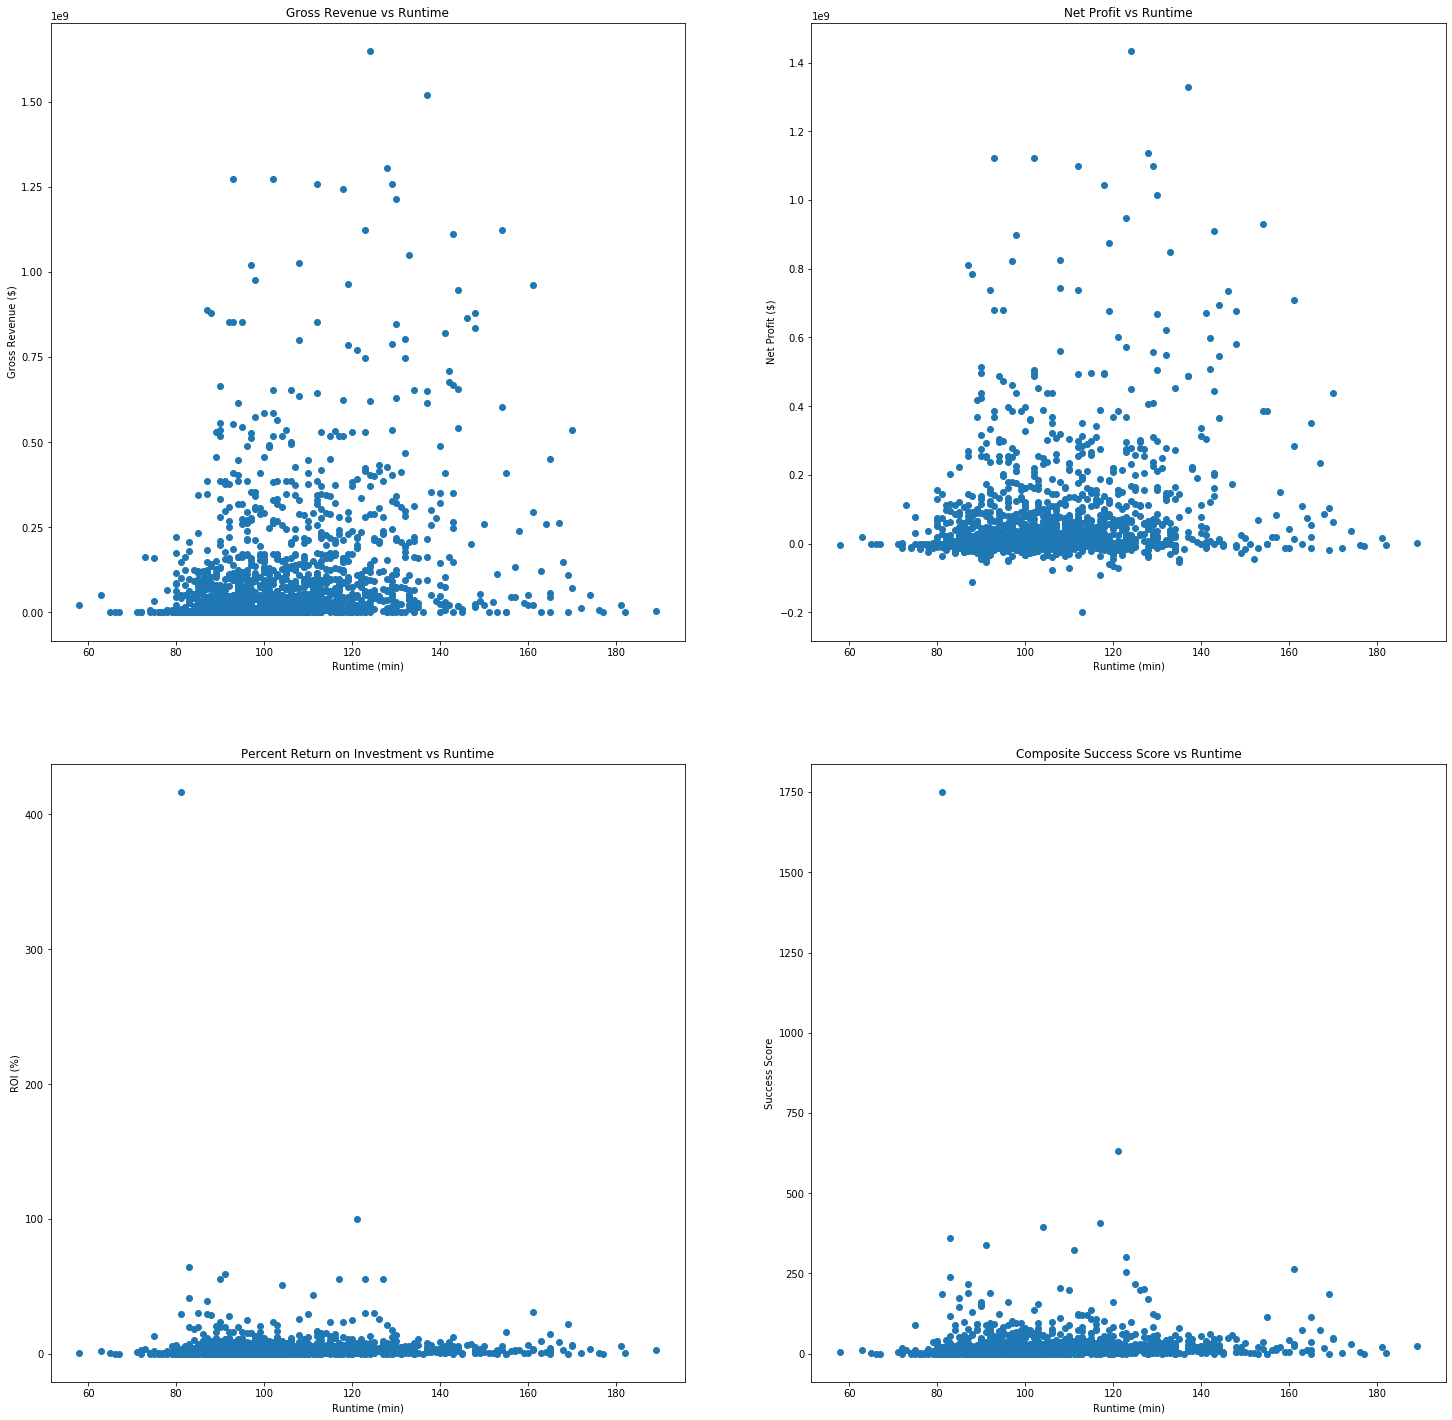

In [29]:
# Graph runtime values against each of the four established measures of success

figure, ax = plt.subplots(2, 2, figsize=(25, 25))

# Establish x and y values for plots

x=master_table.dropna(subset=["runtime_minutes"], axis=0).sort_values(by='runtime_minutes', ascending=True).runtime_minutes
y0_gross_rev= master_table.dropna(subset=["runtime_minutes"], axis=0).sort_values(by='runtime_minutes', ascending=True).worldwide_gross
y1_net_prof= master_table.dropna(subset=["runtime_minutes"], axis=0).sort_values(by='runtime_minutes', ascending=True).net_profit
y2_roi_percent= master_table.dropna(subset=["runtime_minutes"], axis=0).sort_values(by='runtime_minutes', ascending=True).roi
y3_comp= master_table.dropna(subset=["runtime_minutes"], axis=0).sort_values(by='runtime_minutes', ascending=True).success_score 

# Set axes for all four graphs

ax[0][0].set_title('Gross Revenue vs Runtime')
ax[0][0].set_xlabel('Runtime (min)')
ax[0][0].set_ylabel('Gross Revenue ($)')

ax[0][1].set_title('Net Profit vs Runtime')
ax[0][1].set_xlabel('Runtime (min)')
ax[0][1].set_ylabel('Net Profit ($)')

ax[1][0].set_title('Percent Return on Investment vs Runtime')
ax[1][0].set_xlabel('Runtime (min)')
ax[1][0].set_ylabel('ROI (%)')

ax[1][1].set_title('Composite Success Score vs Runtime')
ax[1][1].set_xlabel('Runtime (min)')
ax[1][1].set_ylabel('Success Score')

# Graph the four plots

ax[0][0].scatter(x, y0_gross_rev)
ax[0][1].scatter(x, y1_net_prof)
ax[1][0].scatter(x, y2_roi_percent)
ax[1][1].scatter(x, y3_comp)

# Calculate correlations between runtime and success indicators

correlations={"Runtime Correlations":{"Gross Revenue":y0_gross_rev.corr(x),
"Net Profit": y1_net_prof.corr(x),
"ROI": y2_roi_percent.corr(x),
"Success Composite":y3_comp.corr(x)}}
correlations

## What Effect Does Production Budget Have on a Movie's Success?

For this analysis, the dataset was sequenced by film production budget. Each of the four established success indicators were then individually plotted against production budget, again as single data points. Correlations between budget and these four success indicators were again calculated to gauge the strength of the relationship between production budget and success.

Overall, there appeared to be a moderately positive correlation between a movie's production budget and its gross revenue and net profit; correlations were calculated to be ~0.77 and ~0.64, respectively. This is maybe to be expected, though, as it shouldn't be a surprise that a movie earns money often at the same magnitude as the amount it took to produce. Perhaps a more meaningful indicator to focus on here, then, would be ROI since it, by definition, normalizes revenue by cost. The correlation between budget and ROI is very weak, which implies that production budget may not be an influential driver for succes. It is worth noting, however, that the relationship between ROI and production budget is negative (albeit weak), meaning that overall, lower-budget movies may have more potential to be profitable.

{'Production Budget Correlations': {'Gross Revenue': 0.7701096536061842,
  'Net Profit': 0.6354765183991741,
  'ROI': -0.03054305900454562,
  'Success Composite': -0.02557296524216599}}

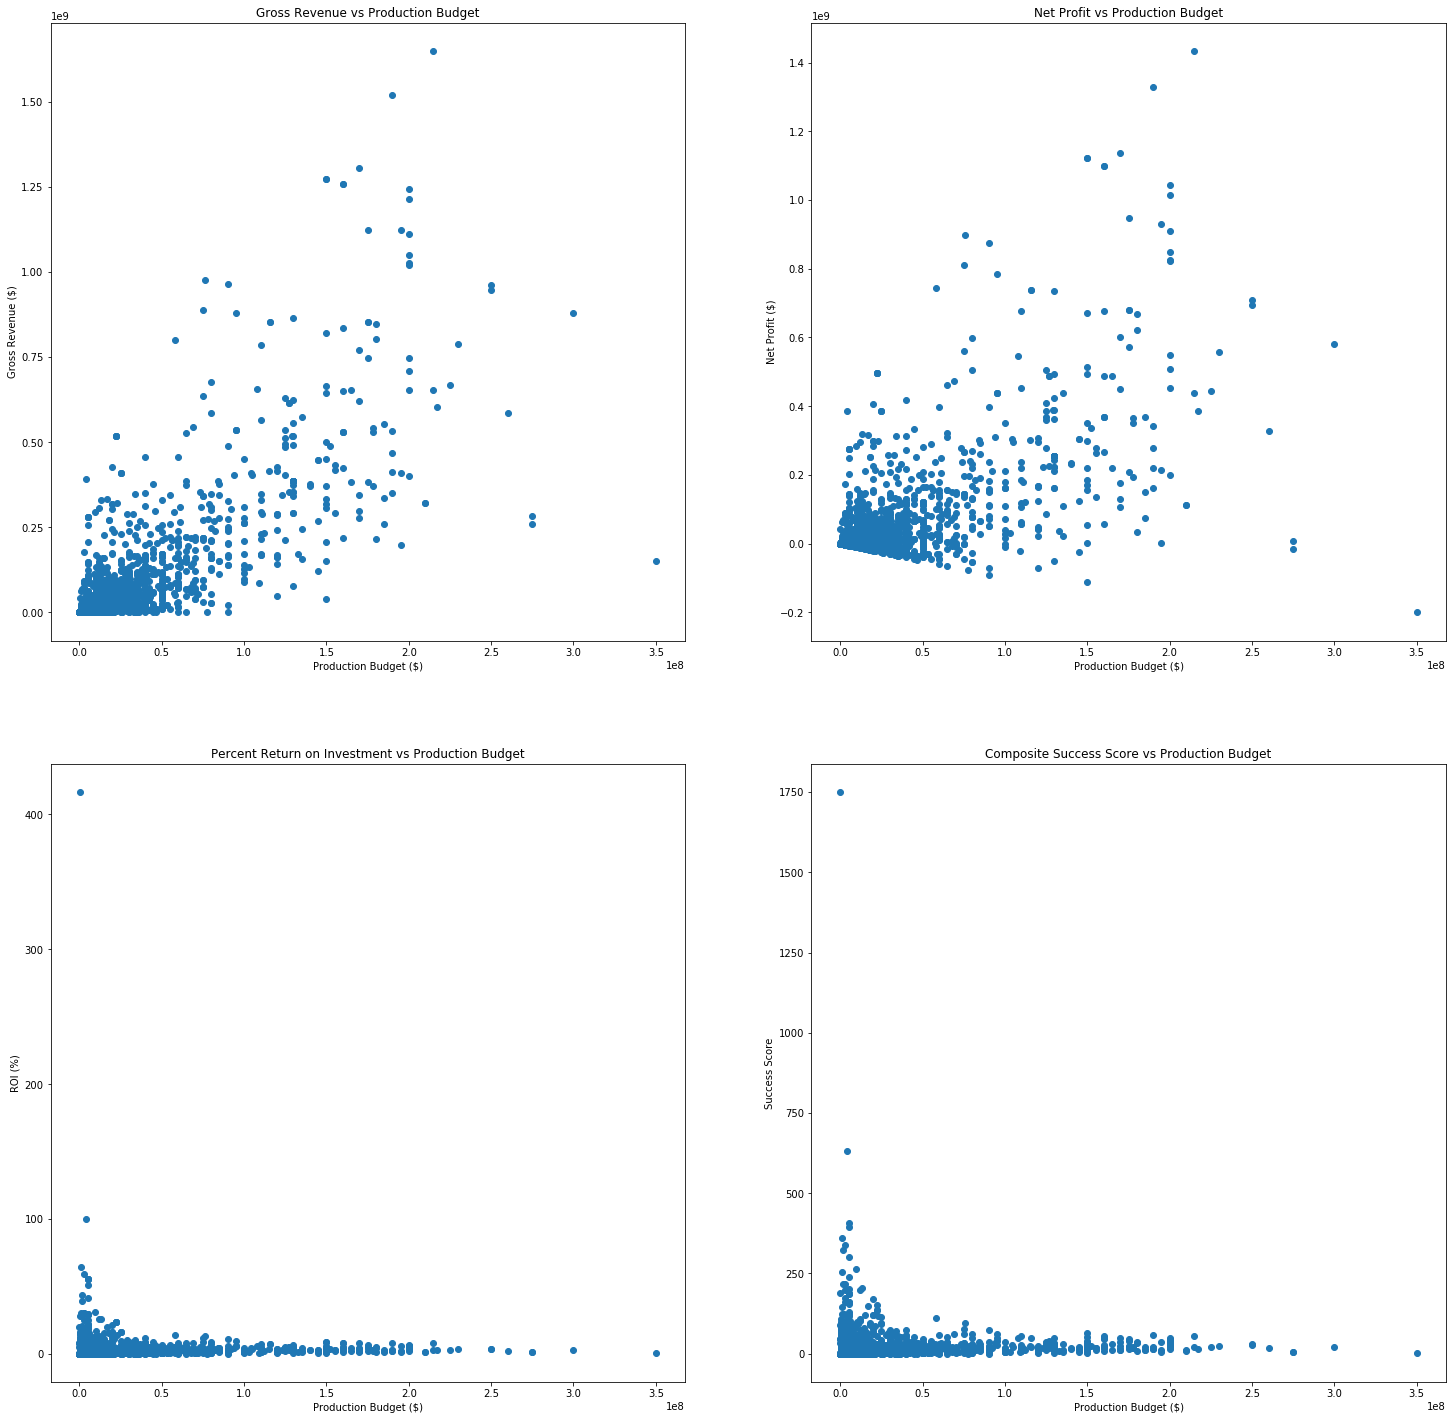

In [30]:
# Graph runtime values against each of the four established measures of success

figure, ax = plt.subplots(2, 2, figsize=(25, 25))

# Establish x and y values for plots

x=master_table.production_budget
y0_gross_rev= master_table.worldwide_gross
y1_net_prof= master_table.worldwide_gross-master_table.production_budget
y2_roi_percent= master_table.worldwide_gross/master_table.production_budget
y3_comp= master_table.success_score 

# Set axes for all four graphs

ax[0][0].set_title('Gross Revenue vs Production Budget')
ax[0][0].set_xlabel('Production Budget ($)')
ax[0][0].set_ylabel('Gross Revenue ($)')

ax[0][1].set_title('Net Profit vs Production Budget')
ax[0][1].set_xlabel('Production Budget ($)')
ax[0][1].set_ylabel('Net Profit ($)')

ax[1][0].set_title('Percent Return on Investment vs Production Budget')
ax[1][0].set_xlabel('Production Budget ($)')
ax[1][0].set_ylabel('ROI (%)')

ax[1][1].set_title('Composite Success Score vs Production Budget')
ax[1][1].set_xlabel('Production Budget ($)')
ax[1][1].set_ylabel('Success Score')

# Graph the four plots

ax[0][0].scatter(x, y0_gross_rev)
ax[0][1].scatter(x, y1_net_prof)
ax[1][0].scatter(x, y2_roi_percent)
ax[1][1].scatter(x, y3_comp)

# Calculate correlations between runtime and success indicators

correlations={"Production Budget Correlations":{"Gross Revenue":y0_gross_rev.corr(x),
"Net Profit":y1_net_prof.corr(x),
"ROI":y2_roi_percent.corr(x),
"Success Composite":y3_comp.corr(x)}}
correlations

## What Effect Does Target Audience Have on a Movie's Success?

Finally, the influence of a movie's target audience on success was explored. MPAA rating ("G", "PG", "PG-13", "R", etc.) was used to gauge intended viewer audience, specifically in terms of age grouping. As this data was not complete in the cleaned data set, this information was taken from IMDB's website via web request for all movies present in the used data set. The process of culling this data can be seen below, followed by the plots of MPAA rating measured against each success indicator.

Overwhelmingly, it appears that movies made for wider age groups are generally more successful (that is, not G-rated movies that would typically be for very young audiences or R-rated movies that would be for older ones). The "PG" MPAA rating had by far the highest gross revenue and net profit values. Return on investment seems to be high for all rating types in general but skews towards ratings that denote wider audiences ("PG" and "PG-13").

In [31]:
# Import relevant python packages

import requests
import sys
import numpy as np
import time
from bs4 import BeautifulSoup

# Request MPAA rating info from IMDB for all films present in the master data set
# Funnel results into "ratings_list" variable

tconst_list=list(master_table.tconst)
ratings_list=[]

for tconst in tconst_list:
    id=tconst
    page = requests.get("https://www.imdb.com/title/" + id + "/")
    soup = BeautifulSoup(page.content, 'html.parser')
    ratings=soup.find(id="titleStoryLine")
    try:
        rate=ratings.find_all(class_="txt-block")[1].text.strip()
        ratings_list.append(rate.split("\n"))
        time.sleep(.01)
    except:
        rate=ratings.find_all(class_="txt-block")[0].text.strip()
        ratings_list.append(rate.split("\n"))
        time.sleep(.01)

<BarContainer object of 4 artists>

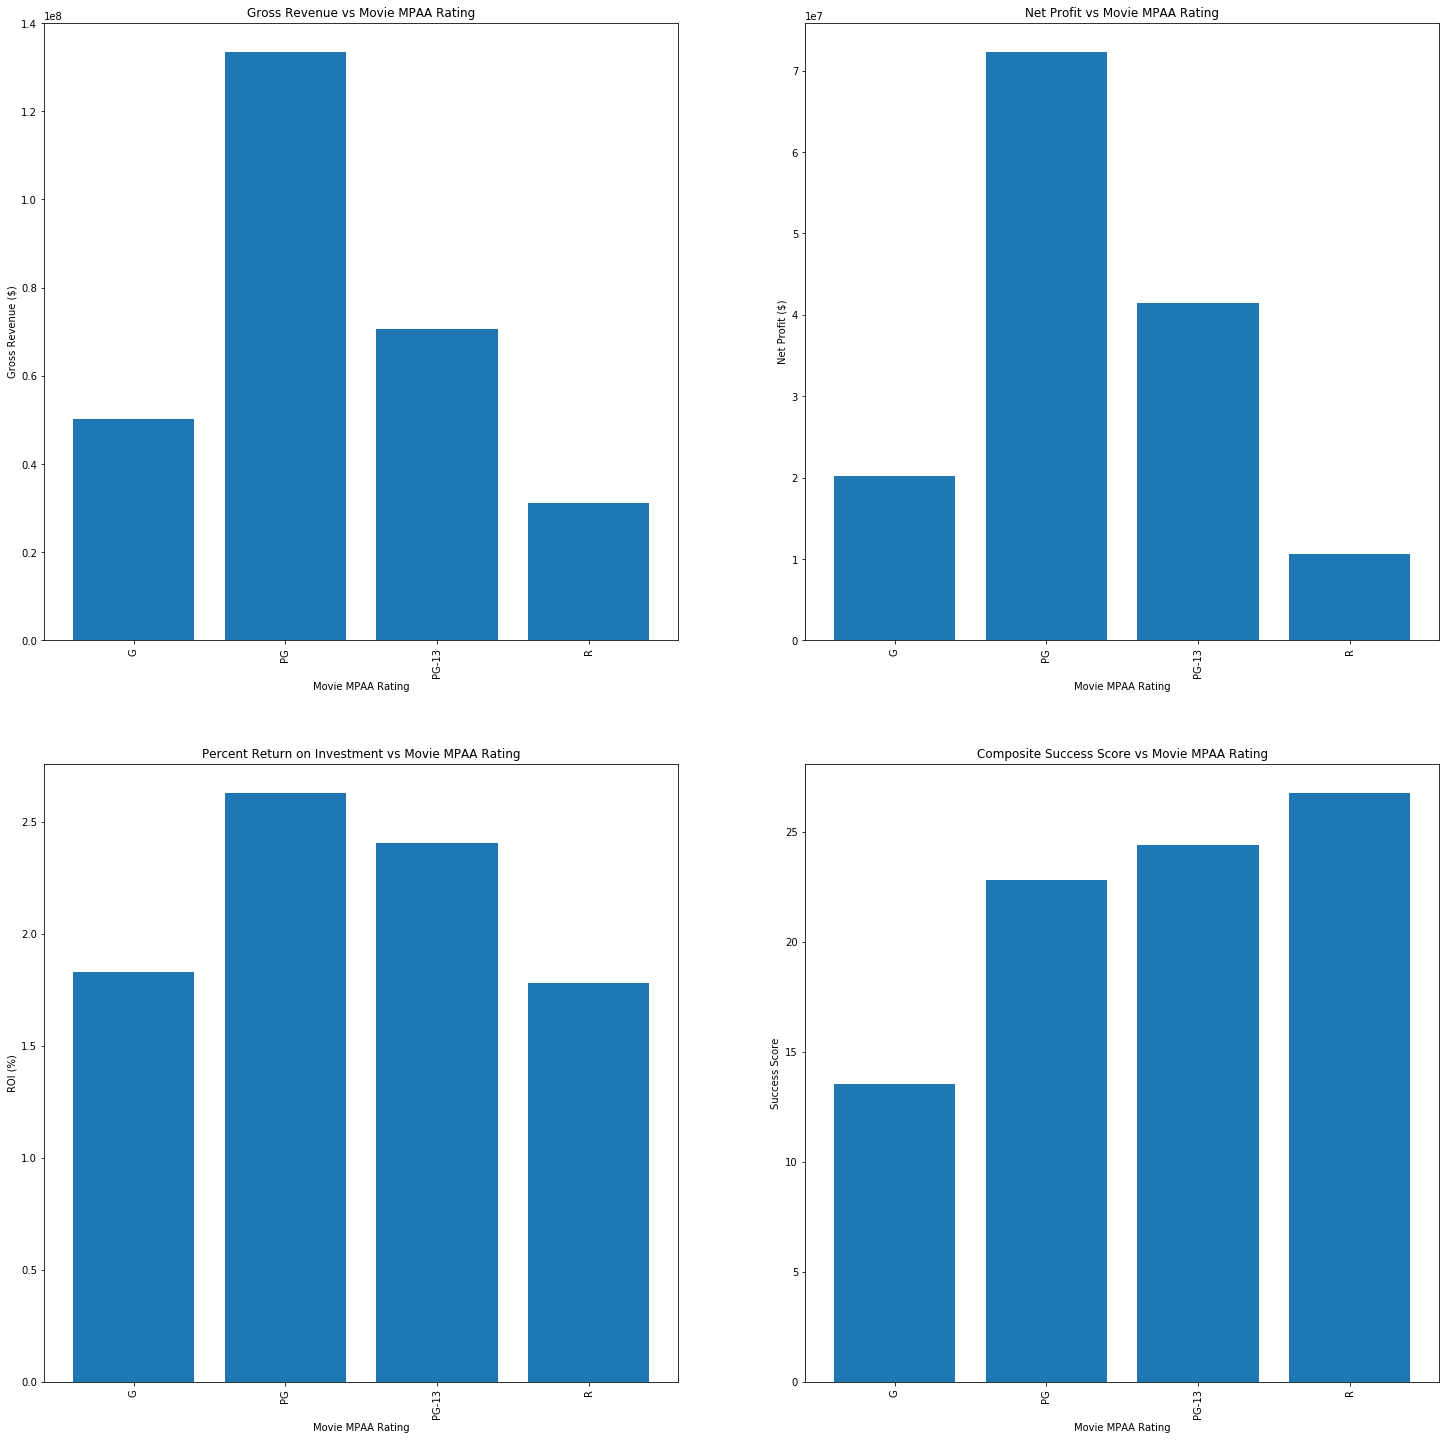

In [32]:
# Make copy of data from web
import copy
ratings_list_copy=copy.deepcopy(ratings_list)

# Reformat MPAA info and extract purely the actual rating string

mindex=list(range(0, len(ratings_list)))

for mi in mindex:
    cindex=list(range(0, len(ratings_list_copy[mi])))
    for ci in cindex:
        if "ated R " in ratings_list_copy[mi][ci]:
            ratings_list_copy[mi][ci]="R"
        elif "R for " in ratings_list_copy[mi][ci]:
            ratings_list_copy[mi][ci]="R"
        elif "13 for" in ratings_list_copy[mi][ci]:
            ratings_list_copy[mi][ci]="PG-13"
        elif "PG for" in ratings_list_copy[mi][ci]:
            ratings_list_copy[mi][ci]="PG"
        elif "Y7" in ratings_list_copy[mi][ci]:
            ratings_list_copy[mi][ci]="G"
        elif "TV-MA" in ratings_list_copy[mi][ci]:
            ratings_list_copy[mi][ci]="R"
        elif "TV-14" in ratings_list_copy[mi][ci]:
            ratings_list_copy[mi][ci]="PG-13"
        elif "TV-PG" in ratings_list_copy[mi][ci]:
            ratings_list_copy[mi][ci]="PG"
        elif "13 on" in ratings_list_copy[mi][ci]:
            ratings_list_copy[mi][ci]="PG-13"
        elif "-13  " in ratings_list_copy[mi][ci]:
            ratings_list_copy[mi][ci]="PG-13"
        elif "Unrated" in ratings_list_copy[mi][ci]:
            ratings_list_copy[mi][ci]="Not Rated"

# Categorizes all movies without rating as "Not Rated"
            
def empty_check(movies):
    rate_list=[]
    for movie in movies:
        rating=""
        for comment in movie:
            if comment=="R" or comment=="PG-13" or comment=="PG" or comment=="G" or comment=="Not Rated":
                rating=comment
        if rating=="":
            rating="Not Rated"
        rate_list.append(rating)    
    return rate_list

full_rating_list=empty_check(ratings_list_copy)

# Create new dataframe of rating data and unique movie ID
# Merge new rating dataframe to master dataset and group by each overall rating

rating_table=pd.DataFrame({"tconst":tconst_list, "mpaa_rating":full_rating_list})
complete_rating_table=pd.merge(rating_table, master_table, how="left", on="tconst")
complete_rating_table.groupby("mpaa_rating").median()

# Graph MPAA rating values against each of the four established measures of success

figure, ax = plt.subplots(2, 2, figsize=(25, 25))

# Establish x and y values for plots

x=complete_rating_table.groupby("mpaa_rating").median().index
y0_gross_rev= complete_rating_table.groupby("mpaa_rating").median().worldwide_gross
y1_net_prof= complete_rating_table.groupby("mpaa_rating").median().net_profit
y2_roi_percent= complete_rating_table.groupby("mpaa_rating").median().roi
y3_comp= complete_rating_table.groupby("mpaa_rating").mean().success_score 

# Set axes for all four graphs

ax[0][0].set_title('Gross Revenue vs Movie MPAA Rating')
ax[0][0].set_xlabel('Movie MPAA Rating')
ax[0][0].set_ylabel('Gross Revenue ($)')

ax[0][1].set_title('Net Profit vs Movie MPAA Rating')
ax[0][1].set_xlabel('Movie MPAA Rating')
ax[0][1].set_ylabel('Net Profit ($)')

ax[1][0].set_title('Percent Return on Investment vs Movie MPAA Rating')
ax[1][0].set_xlabel('Movie MPAA Rating')
ax[1][0].set_ylabel('ROI (%)')

ax[1][1].set_title('Composite Success Score vs Movie MPAA Rating')
ax[1][1].set_xlabel('Movie MPAA Rating')
ax[1][1].set_ylabel('Success Score')

# Remove "Not Rated" category from graphs, as it's not relevant in finding target agegroup

x=[x[0], x[2], x[3], x[4]]
y0_gross_rev=[y0_gross_rev[0], y0_gross_rev[2], y0_gross_rev[3], y0_gross_rev[4]]
y1_net_prof=[y1_net_prof[0], y1_net_prof[2], y1_net_prof[3], y1_net_prof[4]]
y2_roi_percent=[y2_roi_percent[0], y2_roi_percent[2], y2_roi_percent[3], y2_roi_percent[4]]
y3_comp=[y3_comp[0], y3_comp[2], y3_comp[3], y3_comp[4]]

ax[0][0].set_xticklabels(x,rotation=90)
ax[0][1].set_xticklabels(x,rotation=90)
ax[1][0].set_xticklabels(x,rotation=90)
ax[1][1].set_xticklabels(x,rotation=90)

# Graph the four plots

ax[0][0].bar(x, y0_gross_rev)
ax[0][1].bar(x, y1_net_prof)
ax[1][0].bar(x, y2_roi_percent)
ax[1][1].bar(x, y3_comp)



# Conclusion

In general conclusions and recommendations are able to be made about each of the examined film characteristics and their influence on success:
<ul>
<li><b>Genre:</b> Out of all genres, the recommendation would be to make a movie in the Animation or Adventure genres, as they are the most reliably successful.</li>
<li><b>Runtime:</b> The recommendation is to make at least a feature-length film (~80 minutes). Otherwise, this trait seems to have no strong effect on success.</li>
<li><b>Production Budget:</b> Although this trait didn't seem to have too much an influence on success, it is recommended to produce many lower budget movies as opposed to a handful higher budget movies. If the budget doesn't seem to have too great of an impact on an individual movie's success, Microsoft should prioritize creating more content for their service in the form of cheaper films and shows as opposed to a handful of more expensive ones.</li>
<li><b>Target Audience:</b> The recommendation is to create films open to wider audiences as opposed to just generally children or adult ones.</li>
<li><b>Director:</b> The recommendation is hire either John Woo or Jim Jarmusch, with Jim Jarmusch being the best overall hire for profitability</li>
<li><b>Composer:</b> The recommendation is best off of a comparison between the composers linked to the highest grossing movies. With that in mind, any choice would be worthwhile. The absolute best choice, however, would be Ed Côrtes for composer.</li>
<li><b>Year:</b> The objective of this analysis was to find a trend it movie profitability over the past few years. There was a clear upward trend going up through 2018. This trend reversed and profitability steeply declined in 2019. This might be a good opportunity for Microsoft to partner with or acquire a struggling movie studio instead of creating a whole new one on its own.</li>
</ul>

## Next Steps

Further analysis into each of the factors tested above may produce more accurate and/or specific and actionable insights. Moving into the future, we could look at the following: 

 - Model the salary of directors vs median movie ROI for that director
 - Model composers' genre variations to find most versatile composer
 - Model line of best fit for year to find a usable trendline
 - Overall, analyze each of our seven examined characteristics over time as opposed to all at once to identify recent trends in the industry and capitalize on those
 - Microsoft should develop a business strategy, defining what they ultimately want to get out of their new studio and service. With a defined strategic goal in mind, success criteria can be further expanded upon and researched (e.g. if Microsoft decides they want to focus on competing with streaming competitors as opposed to pure profitability, perhaps research can delve further into content creation and expanding market share as opposed to financial indicators like ROI.)